In [113]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import string
import re
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud

from sklearn.decomposition import TruncatedSVD
from sklearn import decomposition
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,f1_score,roc_auc_score

%matplotlib inline

Import the data into a dataframe

In [114]:
data = pd.read_excel('C:\\Analytix\\Git\\Analytix\\Projects\\5.Bank review\\BankReviews.xlsx')
data.head()

Date  Stars                                            Reviews  \
0 2017-04-10      5  Great job, Wyndham Capital! Each person was pr...   
1 2017-02-10      5  Matthew Richardson is professional and helpful...   
2 2017-08-21      5  We had a past experience with Wyndham Mortgage...   
3 2017-12-17      5  We have been dealing with Brad Thomka from the...   
4 2016-05-27      5  I can't express how grateful I am for the supp...   

                   BankName  
0  Wyndham Capital Mortgage  
1  Wyndham Capital Mortgage  
2  Wyndham Capital Mortgage  
3  Wyndham Capital Mortgage  
4  Wyndham Capital Mortgage

In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
Date        505 non-null datetime64[ns]
Stars       505 non-null int64
Reviews     505 non-null object
BankName    505 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 15.9+ KB


There are only two categories for star rating.

In [116]:
data.Stars.value_counts()

5    410
1     95
Name: Stars, dtype: int64

Drop the below variables as it is not relevant for model building

In [117]:
data.drop(columns=['Date','BankName'], inplace=True)

Find the length of each review

In [118]:
data['length_Review'] = data['Reviews'].apply(len)
data.head()

Stars                                            Reviews  length_Review
0      5  Great job, Wyndham Capital! Each person was pr...            126
1      5  Matthew Richardson is professional and helpful...            159
2      5  We had a past experience with Wyndham Mortgage...            462
3      5  We have been dealing with Brad Thomka from the...            605
4      5  I can't express how grateful I am for the supp...            341

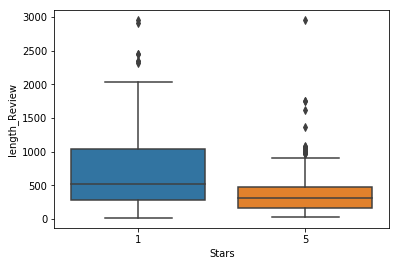

In [119]:
sns.boxplot(x='Stars', y='length_Review', data=data)
plt.show()

In [120]:
#Analyse whether the length of Review has any effect on the Stars rating
d1 = data.groupby(by=['Stars'])[['length_Review']].mean()
d1

length_Review
Stars               
1         776.968421
5         362.339024

The length of negative reviews is more compared to the length of positive reviews.

In [121]:
X = data.Reviews
y = data.Stars

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=123)

Obtain the stopwords in english

In [122]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arundev.satheesan\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!


True

In [123]:
eng_stopwords = set(stopwords.words("english"))

Custom function for removing all the numerical and other alphanumeric characters

In [124]:
#Abbrevations and Words correction
def cleanText(doc):
    doc = doc.lower()
    doc = doc.strip()
    doc = re.sub(r' +', ' ', doc)
    doc = re.sub(r"[-()\"#/@;:{}`+=~|.!?,'0-9]", "", doc)
    return(doc)

Custom function for removing all punctuations and all the stop words

In [125]:
def processText(doc):
    doc = doc.apply(lambda x: " ".join(x for x in x.split() if x not in string.punctuation))
    doc = doc.apply(lambda x: " ".join(x for x in x.split() if x not in eng_stopwords))
    return doc

Test the custom function

In [126]:
s = 'The vectorizer creates unigrams, bigrams and remove stop words like - the:'
cleanText(s)

'the vectorizer creates unigrams bigrams and remove stop words like  the'

Apply both the functions on train and test data

In [127]:
X_train = X_train.apply(lambda x: cleanText(x))
X_test = X_test.apply(lambda x: cleanText(x))

In [128]:
X_train=processText(X_train)
X_test=processText(X_test)

Create a Count Vectorizer

In [129]:
count_vect = CountVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1), 
                             min_df=5, 
                             encoding='latin-1' , 
                             max_features=800)
xtrain_count = count_vect.fit_transform(X_train)
xtest_count = count_vect.transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(xtrain_count)
X_test_tfidf = tfidf_transformer.transform(xtest_count)

In [130]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1, 2), max_features=800)
tfidf_vect_ngram.fit(X_train)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

In [131]:
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(1,2), max_features=800)
tfidf_vect_ngram_chars.fit(X_train)
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_train) 
xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_test)

In [132]:
dtm = pd.DataFrame(X_train_tfidf.toarray(), columns=count_vect.get_feature_names())
dtm.head()

aaron      able  absolutely    accept  accommodating  account  accurate  \
0    0.0  0.137798         0.0  0.000000            0.0      0.0       0.0   
1    0.0  0.000000         0.0  0.134121            0.0      0.0       0.0   
2    0.0  0.000000         0.0  0.000000            0.0      0.0       0.0   
3    0.0  0.000000         0.0  0.000000            0.0      0.0       0.0   
4    0.0  0.000000         0.0  0.000000            0.0      0.0       0.0   

     across  adam      adan    ...     worked   working  works  worth  \
0  0.000000   0.0  0.000000    ...        0.0  0.119645    0.0    0.0   
1  0.000000   0.0  0.000000    ...        0.0  0.000000    0.0    0.0   
2  0.000000   0.0  0.000000    ...        0.0  0.000000    0.0    0.0   
3  0.000000   0.0  0.000000    ...        0.0  0.000000    0.0    0.0   
4  0.213055   0.0  0.218426    ...        0.0  0.000000    0.0    0.0   

      would   wouldnt  wyndham  year     years       yet  
0  0.086061  0.000000      0.0   0.0  0.000000  0.000000  
1  0.000000  0.126522      0.0   0.0  0.091608  0.000000  
2  0.000000  0.000000      0.0   0.0  0.000000  0.465838  
3  0.000000  0.000000      0.0   0.0  0.000000  0.000000  
4  0.000000  0.000000      0.0   0.0  0.000000  0.000000  

[5 rows x 579 columns]

#### Classification Modelling

1. Naive Bayes

In [133]:
nbM = MultinomialNB()
nbM.fit(xtrain_count,y_train)
prediction_train = nbM.predict(xtrain_count)
predictions = nbM.predict(xtest_count)
print("Confusion matrix for test data:")
print(confusion_matrix(y_true=y_test, y_pred=predictions))

print("")
print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(prediction_train, y_train)))
print("The precision score for prediction is : {}".format(metrics.precision_score(prediction_train, y_train)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(prediction_train, y_train)))
print("")

print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(predictions, y_test)))
print("The precision score for prediction is : {}".format(metrics.precision_score(predictions, y_test)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(predictions, y_test)))

Confusion matrix for test data:
[[ 27   4]
 [  4 117]]

The accuracy score for prediction is : 0.9801699716713881
The precision score for prediction is : 0.9375
The f1_score for prediction is : 0.9448818897637795

The accuracy score for prediction is : 0.9473684210526315
The precision score for prediction is : 0.8709677419354839
The f1_score for prediction is : 0.8709677419354839


In [134]:
nbM = MultinomialNB()
nbM.fit(X_train_tfidf,y_train)
predictions = nbM.predict(X_test_tfidf)
prediction_train = nbM.predict(X_train_tfidf)
print("Confusion matrix:")
print(confusion_matrix(y_true=y_test, y_pred=predictions))

print("")
print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(prediction_train, y_train)))
print("The precision score for prediction is : {}".format(metrics.precision_score(prediction_train, y_train)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(prediction_train, y_train)))
print("")

print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(predictions, y_test)))
print("The precision score for prediction is : {}".format(metrics.precision_score(predictions, y_test)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(predictions, y_test)))

Confusion matrix:
[[ 17  14]
 [  1 120]]

The accuracy score for prediction is : 0.9575070821529745
The precision score for prediction is : 0.765625
The f1_score for prediction is : 0.8672566371681416

The accuracy score for prediction is : 0.9013157894736842
The precision score for prediction is : 0.5483870967741935
The f1_score for prediction is : 0.6938775510204082


In [135]:
nbM = MultinomialNB()
nbM.fit(xtrain_tfidf_ngram,y_train)
predictions = nbM.predict(xtest_tfidf_ngram)
prediction_train = nbM.predict(xtrain_tfidf_ngram)
print("Confusion matrix:")
print(confusion_matrix(y_true=y_test, y_pred=predictions))

print("")
print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(prediction_train, y_train)))
print("The precision score for prediction is : {}".format(metrics.precision_score(prediction_train, y_train)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(prediction_train, y_train)))
print("")

print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(predictions, y_test)))
print("The precision score for prediction is : {}".format(metrics.precision_score(predictions, y_test)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(predictions, y_test)))

Confusion matrix:
[[ 16  15]
 [  1 120]]

The accuracy score for prediction is : 0.9603399433427762
The precision score for prediction is : 0.78125
The f1_score for prediction is : 0.8771929824561403

The accuracy score for prediction is : 0.8947368421052632
The precision score for prediction is : 0.5161290322580645
The f1_score for prediction is : 0.6666666666666666


In [136]:
nbM = MultinomialNB()
nbM.fit(xtrain_tfidf_ngram_chars,y_train)
predictions = nbM.predict(xtest_tfidf_ngram_chars)
prediction_train = nbM.predict(xtrain_tfidf_ngram_chars)
print("Confusion matrix:")
print(confusion_matrix(y_true=y_test, y_pred=predictions))

print("")
print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(prediction_train, y_train)))
print("The precision score for prediction is : {}".format(metrics.precision_score(prediction_train, y_train)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(prediction_train, y_train)))
print("")

print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(predictions, y_test)))
print("The precision score for prediction is : {}".format(metrics.precision_score(predictions, y_test)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(predictions, y_test)))

Confusion matrix:
[[  0  31]
 [  0 121]]

The accuracy score for prediction is : 0.8186968838526912
The precision score for prediction is : 0.0
The f1_score for prediction is : 0.0

The accuracy score for prediction is : 0.7960526315789473
The precision score for prediction is : 0.0
The f1_score for prediction is : 0.0


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


2. Logistic Regression

In [137]:
logit = LogisticRegression()
logit.fit(xtrain_count,y_train)
predictions = logit.predict(xtest_count)
prediction_train = logit.predict(xtrain_count)
print("Confusion matrix:")
print(confusion_matrix(y_true=y_test, y_pred=predictions))

print("")
print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(prediction_train, y_train)))
print("The precision score for prediction is : {}".format(metrics.precision_score(prediction_train, y_train)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(prediction_train, y_train)))
print("")

print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(predictions, y_test)))
print("The precision score for prediction is : {}".format(metrics.precision_score(predictions, y_test)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(predictions, y_test)))

Confusion matrix:
[[ 24   7]
 [  1 120]]

The accuracy score for prediction is : 0.9943342776203966
The precision score for prediction is : 0.96875
The f1_score for prediction is : 0.9841269841269841

The accuracy score for prediction is : 0.9473684210526315
The precision score for prediction is : 0.7741935483870968
The f1_score for prediction is : 0.8571428571428571


In [138]:
logit = LogisticRegression()
logit.fit(X_train_tfidf,y_train)
predictions = logit.predict(X_test_tfidf)
prediction_train = logit.predict(X_train_tfidf)
print("Confusion matrix:")
print(confusion_matrix(y_true=y_test, y_pred=predictions))

print("")
print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(prediction_train, y_train)))
print("The precision score for prediction is : {}".format(metrics.precision_score(prediction_train, y_train)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(prediction_train, y_train)))
print("")

print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(predictions, y_test)))
print("The precision score for prediction is : {}".format(metrics.precision_score(predictions, y_test)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(predictions, y_test)))

Confusion matrix:
[[  5  26]
 [  1 120]]

The accuracy score for prediction is : 0.9121813031161473
The precision score for prediction is : 0.515625
The f1_score for prediction is : 0.6804123711340206

The accuracy score for prediction is : 0.8223684210526315
The precision score for prediction is : 0.16129032258064516
The f1_score for prediction is : 0.27027027027027023


In [139]:
logit = LogisticRegression()
logit.fit(xtrain_tfidf_ngram,y_train)
predictions = logit.predict(xtest_tfidf_ngram)
prediction_train = logit.predict(xtrain_tfidf_ngram)
print("Confusion matrix:")
print(confusion_matrix(y_true=y_test, y_pred=predictions))

print("")
print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(prediction_train, y_train)))
print("The precision score for prediction is : {}".format(metrics.precision_score(prediction_train, y_train)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(prediction_train, y_train)))
print("")

print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(predictions, y_test)))
print("The precision score for prediction is : {}".format(metrics.precision_score(predictions, y_test)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(predictions, y_test)))

Confusion matrix:
[[  3  28]
 [  1 120]]

The accuracy score for prediction is : 0.9065155807365439
The precision score for prediction is : 0.484375
The f1_score for prediction is : 0.6526315789473685

The accuracy score for prediction is : 0.8092105263157895
The precision score for prediction is : 0.0967741935483871
The f1_score for prediction is : 0.1714285714285714


In [140]:
logit = LogisticRegression()
logit.fit(xtrain_tfidf_ngram_chars,y_train)
predictions = logit.predict(xtest_tfidf_ngram_chars)
prediction_train = logit.predict(xtrain_tfidf_ngram_chars)
print("Confusion matrix:")
print(confusion_matrix(y_true=y_test, y_pred=predictions))

print("")
print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(prediction_train, y_train)))
print("The precision score for prediction is : {}".format(metrics.precision_score(prediction_train, y_train)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(prediction_train, y_train)))
print("")

print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(predictions, y_test)))
print("The precision score for prediction is : {}".format(metrics.precision_score(predictions, y_test)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(predictions, y_test)))

Confusion matrix:
[[  0  31]
 [  0 121]]

The accuracy score for prediction is : 0.8186968838526912
The precision score for prediction is : 0.0
The f1_score for prediction is : 0.0

The accuracy score for prediction is : 0.7960526315789473
The precision score for prediction is : 0.0
The f1_score for prediction is : 0.0


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


3. Support Vector Classifier

In [141]:
svc = SVC()
svc.fit(xtrain_count,y_train)
predictions = svc.predict(xtest_count)
prediction_train = svc.predict(xtrain_count)
print("Confusion matrix:")
print(confusion_matrix(y_true=y_test, y_pred=predictions))

print("")
print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(prediction_train, y_train)))
print("The precision score for prediction is : {}".format(metrics.precision_score(prediction_train, y_train)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(prediction_train, y_train)))
print("")

print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(predictions, y_test)))
print("The precision score for prediction is : {}".format(metrics.precision_score(predictions, y_test)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(predictions, y_test)))

Confusion matrix:
[[  2  29]
 [  1 120]]

The accuracy score for prediction is : 0.8725212464589235
The precision score for prediction is : 0.296875
The f1_score for prediction is : 0.4578313253012048

The accuracy score for prediction is : 0.8026315789473685
The precision score for prediction is : 0.06451612903225806
The f1_score for prediction is : 0.1176470588235294


In [142]:
svc = SVC()
svc.fit(X_train_tfidf,y_train)
predictions = svc.predict(X_test_tfidf)
prediction_train = svc.predict(X_train_tfidf)
print("Confusion matrix:")
print(confusion_matrix(y_true=y_test, y_pred=predictions))

print("")
print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(prediction_train, y_train)))
print("The precision score for prediction is : {}".format(metrics.precision_score(prediction_train, y_train)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(prediction_train, y_train)))
print("")

print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(predictions, y_test)))
print("The precision score for prediction is : {}".format(metrics.precision_score(predictions, y_test)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(predictions, y_test)))

Confusion matrix:
[[  0  31]
 [  0 121]]

The accuracy score for prediction is : 0.8186968838526912
The precision score for prediction is : 0.0
The f1_score for prediction is : 0.0

The accuracy score for prediction is : 0.7960526315789473
The precision score for prediction is : 0.0
The f1_score for prediction is : 0.0


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [143]:
svc = SVC()
svc.fit(xtrain_tfidf_ngram,y_train)
predictions = svc.predict(xtest_tfidf_ngram)
prediction_train = svc.predict(xtrain_tfidf_ngram)
print("Confusion matrix:")
print(confusion_matrix(y_true=y_test, y_pred=predictions))

print("")
print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(prediction_train, y_train)))
print("The precision score for prediction is : {}".format(metrics.precision_score(prediction_train, y_train)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(prediction_train, y_train)))
print("")

print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(predictions, y_test)))
print("The precision score for prediction is : {}".format(metrics.precision_score(predictions, y_test)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(predictions, y_test)))

Confusion matrix:
[[  0  31]
 [  0 121]]

The accuracy score for prediction is : 0.8186968838526912
The precision score for prediction is : 0.0
The f1_score for prediction is : 0.0

The accuracy score for prediction is : 0.7960526315789473
The precision score for prediction is : 0.0
The f1_score for prediction is : 0.0


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [144]:
svc = SVC()
svc.fit(xtrain_tfidf_ngram_chars,y_train)
predictions = svc.predict(xtest_tfidf_ngram_chars)
prediction_train = svc.predict(xtrain_tfidf_ngram_chars)
print("Confusion matrix:")
print(confusion_matrix(y_true=y_test, y_pred=predictions))

print("")
print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(prediction_train, y_train)))
print("The precision score for prediction is : {}".format(metrics.precision_score(prediction_train, y_train)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(prediction_train, y_train)))
print("")

print("The accuracy score for prediction is : {}".format(metrics.accuracy_score(predictions, y_test)))
print("The precision score for prediction is : {}".format(metrics.precision_score(predictions, y_test)))
print("The f1_score for prediction is : {}".format(metrics.f1_score(predictions, y_test)))

Confusion matrix:
[[  0  31]
 [  0 121]]

The accuracy score for prediction is : 0.8186968838526912
The precision score for prediction is : 0.0
The f1_score for prediction is : 0.0

The accuracy score for prediction is : 0.7960526315789473
The precision score for prediction is : 0.0
The f1_score for prediction is : 0.0


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


#### Key positive words/negative words (most frequent words)

Filter out neg and pos reviews

In [145]:
neg_reviews = data[data.Stars == 1]
neg_words = []
for t in neg_reviews.Reviews:
    neg_words.append(t)
neg_words[:2]

['This was the worst experience ever. It was like they had never gone through the process before. I could not get a complete list of the documents required. Every other day it was a new request. The appraiser that they hired made so many mistakes I had to send in corrections and then during the underwriting process they had to go back and make more corrections. Wyndum would continue to ask for copies of documents over and over again. There were many documents that I had to send 3 and 4 times because they "lost" them or was not filed correctly, we went through 4 different people through the process. I would NEVER use them. Awful experience!',
 'A good rate but a very frustrating process, constant delays, decisions made then changed, overwhelmed underwriting team with 3 week back log, rookie mistake related to Texas law that caused an additional 2 week wait. Closing happened almost 6 weeks after it should have. Courteous and professional, but not very knowledgeable and no sense of urgenc

In [146]:
neg_text = pd.Series(neg_words).str.cat(sep=' ')
neg_text[:200]

'This was the worst experience ever. It was like they had never gone through the process before. I could not get a complete list of the documents required. Every other day it was a new request. The app'

In [147]:
pos_reviews = data[data.Stars == 5]
pos_words = []
for t in pos_reviews.Reviews:
    pos_words.append(t)
pos_words[:2]

['Great job, Wyndham Capital! Each person was professional and helped us move through our refinance process smoothly. Thank you!',
 'Matthew Richardson is professional and helpful. He helped us find the correct product for our mortgage. Thank you very much for the excellent service, Matthew!']

In [148]:
pos_text = pd.Series(pos_words).str.cat(sep=' ')
pos_text[:200]

'Great job, Wyndham Capital! Each person was professional and helped us move through our refinance process smoothly. Thank you! Matthew Richardson is professional and helpful. He helped us find the cor'

##### Key Postive Words

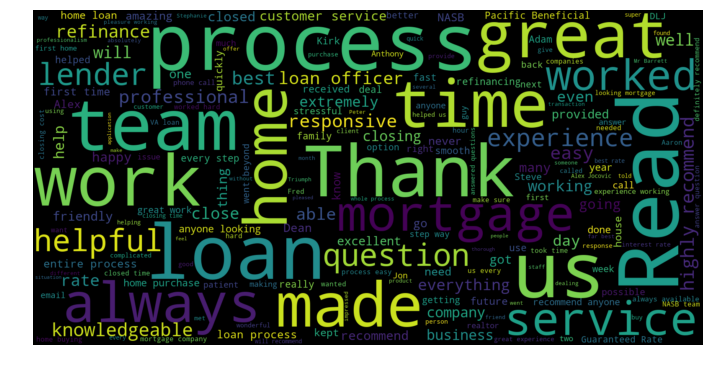

In [149]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(pos_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##### Key Negative Words

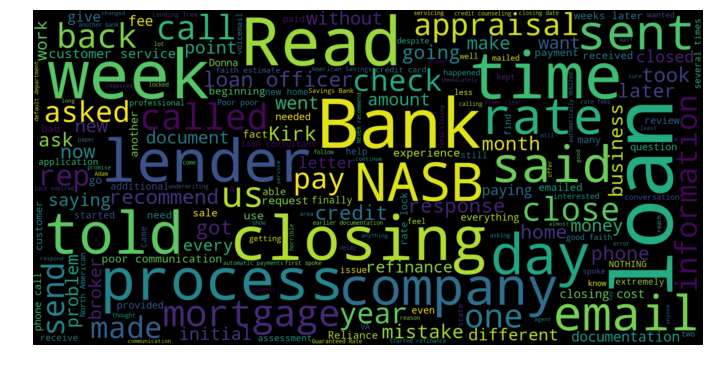

In [150]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Topic Modelling

In [151]:
# train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)
X_topics = lda_model.fit_transform(X_train_tfidf)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

In [152]:
# view the topic models
n_top_words = 50
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

In [153]:
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(topic_word):
        print("Topic %d:" % (idx))
        print([(vocab[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
        print("")

##### Key Topics

In [154]:
print(selected_topics(lda_model, count_vect))

Topic 0:
[('mortgage', 1.7582567690814268), ('ve', 1.681099034581271), ('i', 1.5811265185637946), ('point', 1.564912157926747), ('loan', 1.5293085243073823), ('cost', 1.5157581621424312), ('higher', 1.3277816676205263), ('officer', 1.2552628039723805), ('company', 1.1907551829487597), ('fees', 1.185015315172415)]

Topic 1:
[('oriented', 1.6482276344182807), ('customer', 1.1181546725231744), ('professional', 1.0060204938845716), ('close', 0.0558975007508373), ('everything', 0.055854685933246544), ('quickly', 0.055737124089597356), ('documents', 0.05569760412830722), ('responses', 0.05558599259952077), ('meet', 0.05555679232467597), ('refinancing', 0.05552331263984451)]

Topic 2:
[('thorough', 0.9483210014969518), ('quick', 0.7141132234238539), ('close', 0.6739281798409612), ('review', 0.6516789725040034), ('man', 0.6510892440843291), ('deal', 0.5589883264167516), ('june', 0.5560445630316585), ('jason', 0.5559526303738574), ('honest', 0.5189065375941099), ('amazing', 0.504258502459423)]
